# SETUP
1. Setting up the Google Drive connection
2. Accessing Google Drive
3. Importing the files

In [1]:

#IMPORTING MODULES
import pandas as pd
import numpy as np
import networkx as nx
from google.colab import drive
import matplotlib.pyplot as plt
import missingno as msno


#Mounting the drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:

#Importing the files

pathToFile = "/content/drive/MyDrive/algorithmsProject2"

# PLANES
planes = pd.read_csv(f"{pathToFile}/planes.dat.txt", header = None)
planes.columns = ["Name","IATA","ICAO"]

# ROUTES
routes = pd.read_csv(f"{pathToFile}/routes.dat.txt", header = None)
routes.columns = ["Airline", "AirlineID", "Source", "SourceID", "Destination", "DestinationID", "Codeshare", "Stops", "Equipment"]


In [7]:

# EXAMINING THE DATA FRAMES

##### PLANES #####
# Name: The name of the plane
# ICAO: Three digit alphabetical/digit code distinguishing the aircraft
# IATA: 4+ digit code distinguishing the aircraft
# Because this data file does not have capacities, it does not seem particularly
# useful for what we are tring to do. It may be best to look for an outside data
# source. 

print(planes.head())
print(planes.shape)

planes.head()


                                           Name IATA  ICAO
0                       Aerospatiale (Nord) 262  ND2  N262
1  Aerospatiale (Sud Aviation) Se.210 Caravelle  CRV  S210
2                  Aerospatiale SN.601 Corvette  NDC  S601
3                Aerospatiale/Alenia ATR 42-300  AT4  AT43
4                Aerospatiale/Alenia ATR 42-500  AT5  AT45
(246, 3)


,Name,IATA,ICAO
0,Aerospatiale (Nord) 262,ND2,N262
1,Aerospatiale (Sud Aviation) Se.210 Caravelle,CRV,S210
2,Aerospatiale SN.601 Corvette,NDC,S601
3,Aerospatiale/Alenia ATR 42-300,AT4,AT43
4,Aerospatiale/Alenia ATR 42-500,AT5,AT45


In [6]:

###### ROUTES ######
# Equipment:  the plane used on the flight, corresponds to ICAO codes
# Source: The IATA code for the airport, will be used in the graph
# Destination: The IATA code for the destination airport, will be used in the graph

print(routes.head(n=100))
routes.shape
routes.head(10)


   Airline AirlineID Source  ... Codeshare Stops    Equipment
0       2B       410    AER  ...       NaN     0          CR2
1       2B       410    ASF  ...       NaN     0          CR2
2       2B       410    ASF  ...       NaN     0          CR2
3       2B       410    CEK  ...       NaN     0          CR2
4       2B       410    CEK  ...       NaN     0          CR2
..     ...       ...    ...  ...       ...   ...          ...
95      2J       470    OUA  ...       NaN     0  E70 CRJ M87
96      2J       470    OUA  ...       NaN     0          CRJ
97      2J       470    OUA  ...       NaN     0      M87 CRJ
98      2J       470    OUA  ...       NaN     0          CRJ
99      2J       470    OUA  ...       NaN     0          M87

[100 rows x 9 columns]


,Airline,AirlineID,Source,SourceID,Destination,DestinationID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2
5,2B,410,DME,4029,KZN,2990,NaN,0,CR2
6,2B,410,DME,4029,NBC,6969,NaN,0,CR2
7,2B,410,DME,4029,TGK,\N,NaN,0,CR2
8,2B,410,DME,4029,UUA,6160,NaN,0,CR2
9,2B,410,EGO,6156,KGD,2952,NaN,0,CR2



Data Cleaning and Exploration


In [ ]:
# EXPLORATORY QUERIES AND CLEANING

# Q: How are NA's coded in the data
# A: It appears to be a mix of NaN and \N; these we be handled in cleaning

# Q: Are there non-direct flights in these data? 
# A: Yes
routes[routes["Stops"]>0]

# Q: Do any of them go from NY to San Francisco? 
# A: No, I manually inspected each of the destination airports to confirm this, 
#### so we can remove them

routes = routes[routes.Stops != 1]

# Q: Are they all gone?
# A: Yep!

routes[routes["Stops"]>0]


,Airline,AirlineID,Source,SourceID,Destination,DestinationID,Codeshare,Stops,Equipment


In [ ]:
# Q: Can we split routes by the number of planes that fly them?
# A: Yes

# Creating the temporary dataframe to join later
split = routes['Equipment'].str.split(' ').apply(pd.Series,1).stack()
split.index = split.index.droplevel(-1)
split.name = 'Equipment'

#Handling NA's 
split.replace('', np.nan, inplace=True)
split.dropna(inplace=True)

#Deleting the deprecated equipment column
del routes['Equipment']

#Joining 
routes = routes.join(split)


In [ ]:

# CHANGING THEIR CODED NULL VALUES TO NUMPY NaNs

routes = routes.replace('NaN', np.nan)
routes = routes.replace('\\N', np.nan)
routes.head(10)


,Airline,AirlineID,Source,SourceID,Destination,DestinationID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2
5,2B,410,DME,4029,KZN,2990,NaN,0,CR2
6,2B,410,DME,4029,NBC,6969,NaN,0,CR2
7,2B,410,DME,4029,TGK,NaN,NaN,0,CR2
8,2B,410,DME,4029,UUA,6160,NaN,0,CR2
9,2B,410,EGO,6156,KGD,2952,NaN,0,CR2


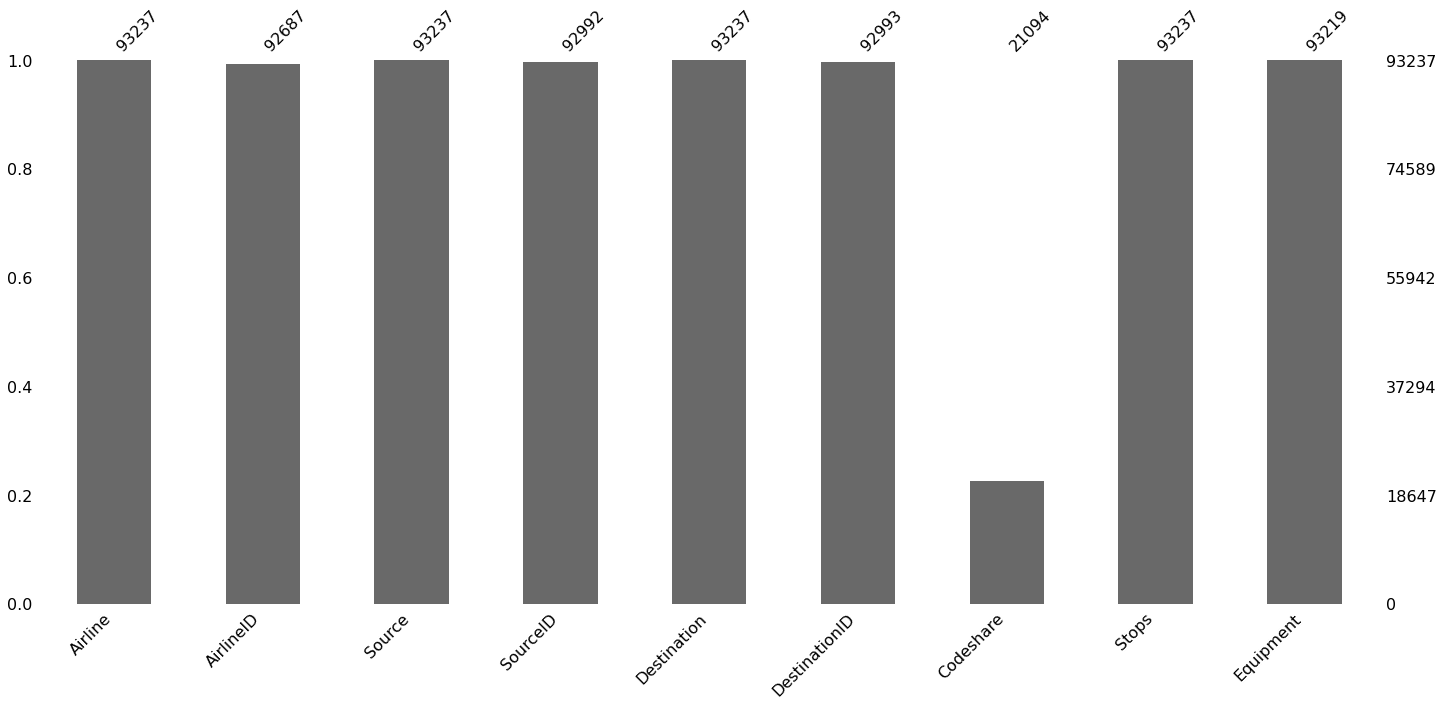

In [ ]:

# CHECKING TO SEE THE NULL CONTENT OF THE ROUTES

msno.bar(routes) 



Joining Routes + Capacity

In [ ]:
##############################
########## CAPACITY ##########
##############################

##### Capacity = NaN for some planes, this is because they are not passenger planes but, in fact, cargo planes
##### which, unless someone is stowing away in the cargo hold, do not carry people. 

# READING IN THE CSV
capacity = pd.read_csv(f"{pathToFile}/capacity.txt", header = None, delimiter= ';')
capacity.columns = ["Airplane","ICAO","Equipment", "Capacity", "Country"]

# HANDLING NA'S 
capacity = capacity.replace('NaN', np.nan)
capacity = capacity.replace('\\N', np.nan)

# CHECKING OUT THE DATA
# capacity[['Equipment', 'Capacity']]

# No duplicated equipment codes
capacity[capacity.duplicated(subset='Equipment')]



# LIMITING THE DATASET TO WHAT WE NEED

flight_capacity = capacity[['Equipment', 'Capacity']]

capacity.head(10)


,Airplane,ICAO,Equipment,Capacity,Country
0,Aerospatiale/Alenia ATR 42-300 / 320,AT43,AT4,50,France
1,Aerospatiale/Alenia ATR 42-500,AT45,AT5,50,France
2,Aerospatiale/Alenia ATR 42/ ATR 72,NaN,ATR,74,France
3,Aerospatiale/Alenia ATR 72,AT72,AT7,74,France
4,Aerospatiale/BAC Concorde,CONC,SSC,128,France
5,Airbus A300 pax,A30B,AB3,200,European consortium
6,Airbus A300-600 pax,A306,AB6,266,European consortium
7,Airbus A310 Freighter,A310,31F,NaN,European consortium
8,Airbus A310 all pax models,A310,310,198,European consortium
9,Airbus A310-200 Freighter,A310,31X,NaN,European consortium


In [ ]:

#  CHECKING FOR NA's
## There are none
print(flight_capacity['Equipment'].isnull().sum())
print(flight_capacity['Equipment'].isnull().sum())


0
0


In [ ]:
# DROPPING NA'S IN ROUTES 
## After looking into these flights, I found that most of them do not run any longer
## futhermore, it is almost impossible to track back what planes fly these routes because
## the data is from 2014. There are only 18 rows with missing plane data, which means that
## we are not losing much information by dropping them. There is little alternatie, as, again, 
## because records for these flights are, from my research, very difficult if not impossible to locate,
## manually imputing the data would be similarly very difficult if not impossible. 

routes = routes.dropna(subset=['Equipment'])


In [ ]:
#CREATING THE FULL ROUTES DATASET
full_routes = routes.merge(flight_capacity, on="Equipment", how="left")

#Showing that no rows were lost in the join
print(full_routes.shape)
print(routes.shape)


(93219, 10)
(93219, 9)


In [ ]:

#Looking for null capacities
## There are nulls. 
print(full_routes['Capacity'].isnull().sum())

## Let's find out where
null_rows = full_routes[full_routes['Capacity'].isnull()]
print(null_rows.Equipment.unique())

## That's a lot of planes. 
## Plan: 
#### Step 1. Find the seating capacity of each plane
#### Step 2. Create a dictionary of the planes and their capacities
#### Step 3. Use fillna to impute data where na's are, this is speedy on big datasets 

# STEP 2.
dict = {'A81' : 85,  'AN4' : 44, 'BNI' : 9, 'CNC' : 19, 'DHP' : 6, 'DHT' : 20, 'BET' : 1,  '73M' :161.5, 
        'SU9' : 1, 'PL2' :9, 'PAG' :9, 'YK2' :120, 'YK4' :24,  'PA2' : 9, 'CN1' : 1, 'CNA' : 1, 'BE1'  :19, 'CNT' : 14, 'MA6' : 1, 
        '77W' : 396, '772' : 368,  'CRK' : 100, '787' : 310, '32B' : 244,  '32A' : 150,  '73C' : 1, 'CRA' : 1, 
        '77L' : 317, '788' : 242,  '76W'  : 1, '74Y' : 1, '74H' :467, '73J' : 1, '73Q' : 1, '75W' : 1, 'F28' : 65, 
        '74N' : 1, 'YN7' : 52, 'IL9' : 262, 'A58' : 75,  '75T' : 1,  'BH2' : 14, 'NDE' : 5, 'BEC' : 2, 'CNJ' : 10,  
        'J32' : 19, 'AB4' : 247, 'PA1' : 9,  'BE9' : 16, 'M1F' : 1, 'YN2' : 17, '76F' : 1,  'CN2' : 19, 'SFB' : 1, 
        '73R' : 150, '73N' : 149,  '77X' : 1, '33X' : 1,  '32C': 107}

# STEP 3.
full_routes.Capacity = full_routes.Capacity.fillna(full_routes.Equipment.map(dict))

# SEEING IF IT WORKED
print(full_routes['Capacity'].isnull().sum())

# IT DID! 
# The NA count for capacity is now 0


6331
['A81' 'AN4' 'BNI' 'CNC' 'DHP' 'DHT' 'BET' '73M' 'SU9' 'PL2' 'PAG' 'YK2'
 'YK4' 'PA2' 'CN1' 'CNA' 'BE1' 'CNT' 'MA6' '77W' '772' 'CRK' '787' '32B'
 '32A' '73C' 'CRA' '77L' '788' '76W' '74Y' '74H' '73J' '73Q' '75W' 'F28'
 '74N' 'YN7' 'IL9' 'A58' '75T' 'BH2' 'NDE' 'BEC' 'CNJ' 'J32' 'AB4' 'PA1'
 'BE9' 'M1F' 'YN2' '76F' 'CN2' 'SFB' '73R' '73N' '77X' '33X' '32C']
0


In [ ]:
# NOW TIME TO HANDLE OTHER NA's 
## The three letter codes are unique to each airport. There are nulls in DestinationID, 
## which makes Source and Destination better choices for labeling the nodes. The three
## letter code is also more recognizable. Practically no one knows the digit ID for airports
## but frequent flyers are bound to know the digit codes for many of these. This makes the 
## graph object more interpretable.  

print(full_routes['Destination'].isnull().sum())
print(full_routes['Source'].isnull().sum())


0
0


In [ ]:
full_routes.head(5)

,Airline,AirlineID,Source,SourceID,Destination,DestinationID,Codeshare,Stops,Equipment,Capacity
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2,50
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2,50
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2,50
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2,50
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2,50


In [ ]:
# CREATING THE EDGELIST 

edgelist = full_routes[['Source', 'Destination', 'Capacity', 'Airline']]
edgelist.head(10)


,Source,Destination,Capacity,Airline
0,AER,KZN,50,2B
1,ASF,KZN,50,2B
2,ASF,MRV,50,2B
3,CEK,KZN,50,2B
4,CEK,OVB,50,2B
5,DME,KZN,50,2B
6,DME,NBC,50,2B
7,DME,TGK,50,2B
8,DME,UUA,50,2B
9,EGO,KGD,50,2B


# And now we create many, many CSV's 

In [ ]:
from google.colab import files

# SAVING FULL INFORMATION
full_routes.to_csv('full_flights.csv') 
files.download('full_flights.csv')

# SAVING THE EDGELIST
edgelist.to_csv('flights_edgelist.csv') 
files.download('flights_edgelist.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# DEPRECATED CODE 

In [ ]:

# Checking how many individual source, destination pairs there are
print(edgelist.groupby(['Source', 'Destination']).ngroups)


37591


In [ ]:

# MAX FLIGHT
## Shape confirms that all airports pairs are retained in this data

edgelist.Capacity = pd.to_numeric(edgelist.Capacity)
max_flights = edgelist.groupby(['Source', 'Destination']).max().reset_index()

# MAX FLIGHT, NO AIRLINE, FOR QUESTION 1
max_flights_na = max_flights.drop('Airline', 1)

# PRINTING 
# to see if everything worked...
# it did! All airport couples were retained with max capacities and corresponding airlines

print(max_flights.head(10))
print(max_flights.shape)
print(max_flights_na.head(10))
print(max_flights_na.shape)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


  Source Destination  Capacity Airline
0    AAE         ALG     162.0      AH
1    AAE         CDG     162.0      AH
2    AAE         IST     162.0      AH
3    AAE         LYS     162.0      AH
4    AAE         MRS     162.0      ZI
5    AAE         ORN      74.0      AH
6    AAE         ORY     124.0      ZI
7    AAL         AAR      34.0      BA
8    AAL         AGP     162.0      DY
9    AAL         ALC     162.0      DY
(37591, 4)
  Source Destination  Capacity
0    AAE         ALG     162.0
1    AAE         CDG     162.0
2    AAE         IST     162.0
3    AAE         LYS     162.0
4    AAE         MRS     162.0
5    AAE         ORN      74.0
6    AAE         ORY     124.0
7    AAL         AAR      34.0
8    AAL         AGP     162.0
9    AAL         ALC     162.0
(37591, 3)


In [ ]:
# SUM FLIGHTS, no airline
sum_edgelist = edgelist.drop(columns='Airline')
sum_edgelist['Capacity'] = pd.to_numeric(sum_edgelist.Capacity)
sum_flights = sum_edgelist.groupby(['Source','Destination']).sum().reset_index()
print(sum_flights.head(10))
print(sum_flights.shape)


  Source Destination  Capacity
0    AAE         ALG     346.0
1    AAE         CDG     162.0
2    AAE         IST     162.0
3    AAE         LYS     162.0
4    AAE         MRS     286.0
5    AAE         ORN      74.0
6    AAE         ORY     234.0
7    AAL         AAR      34.0
8    AAL         AGP     162.0
9    AAL         ALC     162.0
(37591, 3)


In [ ]:

# SUM FLIGHTS, grouped by airline

sum_flights_ga = edgelist.groupby(['Source','Destination', 'Airline']).sum().reset_index()
print(sum_flights_ga.head(10))
print(sum_flights_ga.shape)


  Source Destination Airline  Capacity
0    AAE         ALG      AH     346.0
1    AAE         CDG      AH     162.0
2    AAE         IST      AH     162.0
3    AAE         LYS      AH     162.0
4    AAE         MRS      AH     162.0
5    AAE         MRS      ZI     124.0
6    AAE         ORN      AH      74.0
7    AAE         ORY      AH     110.0
8    AAE         ORY      ZI     124.0
9    AAL         AAR      BA      34.0
(67634, 4)


In [ ]:
# SAVING THESE ALL TO CSVs

# Max flights edgelist 
max_flights_na.to_csv('max_flights_edgelist.csv') 
files.download('max_flights_edgelist.csv')

# Max flights edgelist + airlines
max_flights.to_csv('airline_max_flights_edgelist.csv') 
files.download('airline_max_flights_edgelist.csv')

# Sum flights edgelist
sum_flights.to_csv('sum_flights_edgelist.csv') 
files.download('sum_flights_edgelist.csv')

# Sum flights edgelist + airline
sum_flights_ga.to_csv('airline_sum_flights_edgelist.csv') 
files.download('airline_sum_flights_edgelist.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>